In [26]:
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/lucas/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'funct

In [74]:
import numpy as np
import pandas as pd


import argparse

import glob
import logging

logging.basicConfig(level=logging.DEBUG)


def calc_r(hits: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the distance of each hit from the origin.
    """
    r = np.sqrt(hits.x**2 + hits.y**2) / 10
    return r


def calc_pt(particles: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the transverse momentum of each particle.
    """
    pt = np.sqrt(particles.px**2 + particles.py**2)
    return pt


def calc_z0(hits: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the z-intercept of the track in r-z plane.
    """
    list_of_particles = hits["particle_id"].unique()
    print(hits["particle_id"].nunique())
    z0s = []

    for particle in list_of_particles:
        
        r = hits.loc[hits["particle_id"] == particle, "r"].values
        z = hits.loc[hits["particle_id"] == particle, "z"].values
        
        trk = np.polyfit(z, r, 1)
        # print(f"particle_id = {particle}")
        
        z0 = -trk[1] / trk[0]
        z0s.append(z0)

    results = pd.DataFrame({"particle_id": list_of_particles, "z0": z0s})

    return results


def pre_process(
    list_of_hits: list, list_of_particles: list, list_of_truth: list
) -> pd.DataFrame:

    all_tracks = pd.DataFrame({})
    event_number = 0
    ntracks = []
    for f_hits, f_particles, f_truth in zip(
        list_of_hits, list_of_particles, list_of_truth
    ):
        print(f_hits, f_particles, f_truth)
        # logging.info(f"Running file: f{f_hits}")
        hits = pd.read_csv(f_hits)
        particles = pd.read_csv(f_particles)
        truth = pd.read_csv(f_truth)

        hits["r"] = calc_r(hits)
        hits["x"] = hits["x"] / 10
        hits["y"] = hits["y"] / 10
        hits["z"] = hits["z"] / 10

        particles["pt"] = calc_pt(particles)

        mask_pt = particles["pt"] > 2
        mask_nhits = particles["nhits"] > 4
                
        ntracks.append((mask_pt & mask_nhits).sum())
        
        particles_r = particles.loc[mask_pt & mask_nhits]
        
        truth_r = truth.loc[truth["particle_id"].isin(particles_r["particle_id"])]
        
        hits_r = hits.loc[hits["hit_id"].isin(truth_r["hit_id"])]
        hits_r = pd.merge(hits_r, truth[["hit_id", "particle_id"]], how="left", on="hit_id")

        
        # print(particles_r.shape, truth_r.shape, hits_r.shape)
        trk_z0 = calc_z0(hits_r)
        
        
        event_number+=1
        if event_number >10:
            break

#         truth = truth.loc[truth.particle_id.isin(particles.particle_id)]
#         hits = hits.loc[hits.hit_id.isin(truth.hit_id)]
#         hits = pd.merge(hits, truth[["hit_id", "particle_id"]], how="left", on="hit_id")

#         trk_z0 = calc_z0(hits)
#         trk_z0 = pd.merge(
#             trk_z0, particles[["particle_id", "pt"]], on="particle_id", how="left"
#         )
#         trk_z0["event_number"] = event_number
#         event_number += 1  # increment event number
#         trk_z0.reset_index(inplace=True)
#         trk_z0.rename(columns={"index": "track_number"}, inplace=True)
#         all_tracks = pd.concat([all_tracks, trk_z0])


#     return all_tracks



In [76]:
list_of_cells

['/media/lucas/QS/track_dl/train_1/event000001004-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001008-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001006-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001005-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001001-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001002-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001000-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001003-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001007-cells.csv',
 '/media/lucas/QS/track_dl/train_1/event000001009-cells.csv']

In [79]:
np.sort(list_of_hits)

array(['/media/lucas/QS/track_dl/train_1/event000001000-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001001-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001002-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001003-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001004-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001005-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001006-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001007-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001008-hits.csv',
       '/media/lucas/QS/track_dl/train_1/event000001009-hits.csv'],
      dtype='<U56')

In [80]:


folder = "/media/lucas/QS/track_dl/train_1"

list_of_cells = sorted(glob.glob(folder + "/event00000100*-cells.csv"))
list_of_hits = sorted(glob.glob(folder + "/event00000100*-hits.csv"))
list_of_particles = sorted(glob.glob(folder + "/event00000100*-particles.csv"))
list_of_truth = sorted(glob.glob(folder + "/event00000100*-truth.csv"))

# print(f"processing a total of {len(list_of_cells)} files")

all_tracks = pre_process(list_of_hits, list_of_particles, list_of_truth)

/media/lucas/QS/track_dl/train_1/event000001000-hits.csv /media/lucas/QS/track_dl/train_1/event000001000-particles.csv /media/lucas/QS/track_dl/train_1/event000001000-truth.csv
269
/media/lucas/QS/track_dl/train_1/event000001001-hits.csv /media/lucas/QS/track_dl/train_1/event000001001-particles.csv /media/lucas/QS/track_dl/train_1/event000001001-truth.csv
144
/media/lucas/QS/track_dl/train_1/event000001002-hits.csv /media/lucas/QS/track_dl/train_1/event000001002-particles.csv /media/lucas/QS/track_dl/train_1/event000001002-truth.csv
313
/media/lucas/QS/track_dl/train_1/event000001003-hits.csv /media/lucas/QS/track_dl/train_1/event000001003-particles.csv /media/lucas/QS/track_dl/train_1/event000001003-truth.csv
223
/media/lucas/QS/track_dl/train_1/event000001004-hits.csv /media/lucas/QS/track_dl/train_1/event000001004-particles.csv /media/lucas/QS/track_dl/train_1/event000001004-truth.csv
320
/media/lucas/QS/track_dl/train_1/event000001005-hits.csv /media/lucas/QS/track_dl/train_1/event

In [88]:
all_tracks.z0.describe()

count    406738.000000
mean          0.029599
std          49.419334
min      -12605.740325
25%          -0.394685
50%           0.001528
75%           0.403272
max       17790.604202
Name: z0, dtype: float64

Text(0.5, 1.0, 'trackML train_1 fitted tracks')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='n

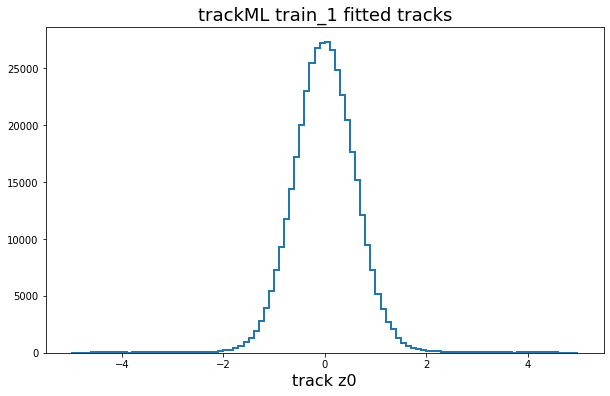

In [103]:
plt.figure(figsize=(10,6))
_ = plt.hist(all_tracks['z0'], bins =100, histtype='step', lw = 2,  range=(-5, 5))
plt.xlabel('track z0',fontsize=16)
plt.title("trackML train_1 fitted tracks", fontsize =18)

In [85]:
all_tracks = pd.read_pickle('../all_tracks.pkl')

In [21]:
ntracks = all_tracks.groupby('event_number')['track_number'].count()

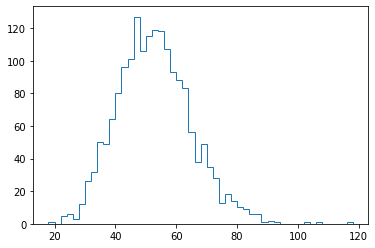

In [82]:
_ = plt.hist(ntracks, bins = 50, histtype='step')

In [107]:
!ls -lh /media/lucas/QS/l1_nnt/trk_25k.pkl

-rw-r--r-- 1 lucas lucas 133M May  2 19:40 /media/lucas/QS/l1_nnt/trk_25k.pkl


In [108]:
cms = pd.read_pickle("/media/lucas/QS/l1_nnt/trk_25k.pkl")

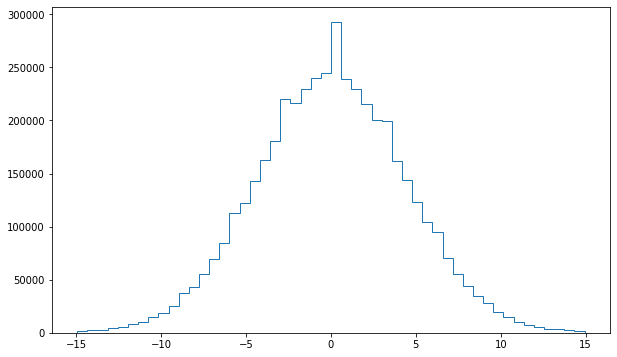

In [111]:
plt.figure(figsize=(10, 6))
_= plt.hist(cms["trk_z0"], histtype='step',bins=50)